In [19]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Clone GitHub repository
!git clone https://github.com/Amirtalebi83/GNN-OptimalPowerFlow.git
%cd GNN-OptimalPowerFlow

# Check the contents of the cloned repo
!ls


Mounted at /content/drive
Cloning into 'GNN-OptimalPowerFlow'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 180 (delta 8), reused 9 (delta 6), pack-reused 168 (from 1)
Receiving objects: 100% (180/180), 64.67 MiB | 14.36 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/GNN-OptimalPowerFlow
'dataset generation'   document  'jupyter notebook'   README.md


In [18]:
# Install PyTorch and PyTorch Geometric
!pip install torch
!pip install torch-geometric
!pip install pandas openpyxl  # For data handling


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00


# **Import Libraries**





In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv, GraphConv, SAGEConv, GATConv, ChebConv
from torch_geometric.data import Data, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set print options for better readability
np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)


In [21]:
def slice_dataset(dataset, percentage):
    data_size = len(dataset)
    return dataset[:int(data_size * percentage / 100)]

def make_dataset(dataset, n_bus):
    x_raw, y_raw = [], []

    for i in range(len(dataset)):
        x_sample, y_sample = [], []
        for n in range(n_bus):
            # Assume P and Q are inputs
            x_sample.append([dataset[i, 4*n+1], dataset[i, 4*n+2]])  # [P, Q]
            y_sample.extend(dataset[i, 4*n+3:4*n+5])  # [V, delta]

        x_raw.append(x_sample)
        y_raw.append(y_sample)

    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    return x_raw, y_raw

def normalize_dataset(x, y):
    x_mean, x_std = torch.mean(x, 0), torch.std(x, 0)
    y_mean, y_std = torch.mean(y, 0), torch.std(y, 0)
    x_norm = (x - x_mean) / x_std
    y_norm = (y - y_mean) / y_std
    return x_norm, y_norm, x_mean, y_mean, x_std, y_std

def denormalize_output(y_norm, y_mean, y_std):
    return y_norm * y_std + y_mean

def MSE(yhat, y):
    return torch.mean((yhat - y) ** 2)


# **Load Dataset**

In [22]:
# Load dataset from Excel files
dataset1 = pd.read_excel('/content/GNN-OptimalPowerFlow/jupyter notebook/dataset/Grid_14 bus_1.xlsx').values
dataset2 = pd.read_excel('/content/GNN-OptimalPowerFlow/jupyter notebook/dataset/Grid_14 bus_2.xlsx').values

# Split the dataset
train_percentage = 100
val_percentage = 100

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 14

# Prepare training and validation data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

# Normalize the data
x_norm_train, y_norm_train, _, _, _, _ = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

# Prepare DataLoader for PyTorch Geometric
edge_index = torch.tensor([[0, 1, 1, 2, 1, 3, 2, 4, 3, 5, 4, 6, 4, 7, 5, 8, 5, 9, 1, 10, 10, 11, 11, 12, 11, 13],
                           [1, 0, 2, 1, 3, 1, 4, 2, 5, 3, 6, 4, 7, 4, 8, 5, 9, 5, 10, 1, 11, 10, 12, 11, 13, 11]], dtype=torch.long)

# Create Data objects for PyTorch Geometric
train_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_train, y_norm_train)]
val_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_val, y_norm_val)]

train_loader = DataLoader(train_data_list, batch_size=1)
val_loader = DataLoader(val_data_list, batch_size=1)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [23]:
edge_index

tensor([[ 0,  1,  1,  2,  1,  3,  2,  4,  3,  5,  4,  6,  4,  7,  5,  8,  5,  9,
          1, 10, 10, 11, 11, 12, 11, 13],
        [ 1,  0,  2,  1,  3,  1,  4,  2,  5,  3,  6,  4,  7,  4,  8,  5,  9,  5,
         10,  1, 11, 10, 12, 11, 13, 11]])

# **Define GNN Model**

We will use a simple GCN as the first model and later extend it to include other GNN topologies:

In [6]:
class My_GNN_Model(nn.Module):
    def __init__(self, in_channels=2, hidden_channels=8, out_channels=2):
        super(My_GNN_Model, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels * n_bus, out_channels * n_bus)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = x.view(-1)
        x = self.lin(x)
        return x.view(-1, 2)

model = My_GNN_Model()


# **Training Loop**

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
epochs = 100

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch)

        # Flatten the prediction to match the target shape
        y_pred = y_pred.view(-1)

        # Compute loss using flattened predictions and targets
        loss = MSE(denormalize_output(y_pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.003972
Epoch 1, Loss: 0.001788
Epoch 2, Loss: 0.002764
Epoch 3, Loss: 0.003041
Epoch 4, Loss: 0.002732
Epoch 5, Loss: 0.002575
Epoch 6, Loss: 0.002350
Epoch 7, Loss: 0.002206
Epoch 8, Loss: 0.002322
Epoch 9, Loss: 0.002365
Epoch 10, Loss: 0.002193
Epoch 11, Loss: 0.002252
Epoch 12, Loss: 0.002420
Epoch 13, Loss: 0.002379
Epoch 14, Loss: 0.002394
Epoch 15, Loss: 0.002610
Epoch 16, Loss: 0.002705
Epoch 17, Loss: 0.002781
Epoch 18, Loss: 0.002755
Epoch 19, Loss: 0.002358
Epoch 20, Loss: 0.002139
Epoch 21, Loss: 0.002146
Epoch 22, Loss: 0.002063
Epoch 23, Loss: 0.002205
Epoch 24, Loss: 0.002235
Epoch 25, Loss: 0.002424
Epoch 26, Loss: 0.002329
Epoch 27, Loss: 0.001747
Epoch 28, Loss: 0.001620
Epoch 29, Loss: 0.001439
Epoch 30, Loss: 0.001635
Epoch 31, Loss: 0.001665
Epoch 32, Loss: 0.001782
Epoch 33, Loss: 0.001450
Epoch 34, Loss: 0.001937
Epoch 35, Loss: 0.001997
Epoch 36, Loss: 0.001634
Epoch 37, Loss: 0.001980
Epoch 38, Loss: 0.002036
Epoch 39, Loss: 0.001731
Epoch 40, 

# **Topologies to Test:**
The following topologies will be tested to compare the effectiveness of different GNN architecture.

Each topology offers different strengths, such as handling local versus long-range relationships, incorporating attention mechanisms, and scaling to larger grid sizes.

1. **Graph Convolutional Networks (GCN):**

 GCN is a basic form of GNN where each node aggregates features from its immediate neighbors. It’s simplicity makes it a good first model. It is widely used for node classification and regression tasks. GCN will serves as a baseline model that can handle local relationships effectively but may struggle with long-range dependencies.

2. **Graph Attention Networks (GAT):**
'GATConv'

GAT assigns different attention weights to each neighboring node during aggregation and help the network focus on the most important nodes. It allows dynamic weighting of neighbors, which is useful when certain nodes (like generator buses) have more influence
in OPF.

3. **Chebyshev Networks (ChebNet):**
'ChebConv'

ChebNet approximates graph convolutions using Chebyshev polynomials and can capture information from nodes multiple hops away without needing many layers. ChebNet can effectively model multi-hop relationships while reducing the need for deep GCNs, which is important for capturing system-wide behavior in the grid.

4. **GraphSAGE (SAmple and aggreGatE):**
'SAGEConv'

GraphSAGE is designed for inductive learning and allows us to sample a fixed-size neighborhood of nodes which will make it scalable to large graphs.
GraphSAGE could be useful for OPF tasks in large power grids, as it can efficiently scale to larger
networks.

5. **GraphConv (GraphConv):**

GraphConv is designed to enhance feature learning by incorporating self-loops (each node aggregates its own feature along with its neighbors).
It performs a weighted sum of neighbor features, including the node’s own feature. This helps in capturing more node-specific information.
It is useful when self-loops or enhanced node feature aggregation can improve model performance. It might perform better on grids where local node information (like generator buses) is crucial.

6. **Multi-Head Graph Attention Networks (MH-GAT):**

Multi-head attention computes multiple
attention distributions in parallel, capturing various aspects of node relationships. This topology
could be valuable for learning different aspects of node and edge interactions, especially when OPF
solutions are influenced by both local and distant nodes

# **Experiment Order:** (and an Idea for the comparison paper?)

**Baseline:** GCN (to set a benchmark).

**Attention-Based:** GATConv (to see if attention helps in OPF tasks).

**Multi-Hop Relationship:** ChebConv (to model long-range dependencies).

**Scalability Test:** SAGEConv (to see how well it scales to larger bus systems).

**Enhanced Node Feature Learning:** GraphConv (to check if self-loops improve performance).

In [14]:
from torch_geometric.nn import GCNConv, GraphConv, SAGEConv, GATConv, ChebConv

class My_GNN_GNN_NN(torch.nn.Module):
    def __init__(self, node_size, feat_in, feat_size1, feat_size2, hidden_size1, output_size, gnn_type='GCN'):
        super(My_GNN_GNN_NN, self).__init__()
        self.feat_in = feat_in
        self.feat_size1 = feat_size1
        self.feat_size2 = feat_size2
        self.hidden_size1 = hidden_size1
        self.output_size = output_size

        # Select GNN Layer Type
        if gnn_type == 'GCN':
            self.conv1 = GCNConv(feat_in, feat_size1)
            self.conv2 = GCNConv(feat_size1, feat_size2)
        elif gnn_type == 'GraphConv':
            self.conv1 = GraphConv(feat_in, feat_size1)
            self.conv2 = GraphConv(feat_size1, feat_size2)
        elif gnn_type == 'SAGEConv':
            self.conv1 = SAGEConv(feat_in, feat_size1)
            self.conv2 = SAGEConv(feat_size1, feat_size2)
        elif gnn_type == 'GATConv':
            self.conv1 = GATConv(feat_in, feat_size1)
            self.conv2 = GATConv(feat_size1, feat_size2)
        elif gnn_type == 'ChebConv':
            self.conv1 = ChebConv(feat_in, feat_size1, K=2)
            self.conv2 = ChebConv(feat_size1, feat_size2, K=2)
        else:
            raise ValueError("Invalid GNN type. Choose from 'GCN', 'GraphConv', 'SAGEConv', 'GATConv', 'ChebConv'.")

        self.lin1 = Linear(node_size * feat_size2, hidden_size1)
        self.lin2 = Linear(hidden_size1, output_size)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        x = self.conv2(x, edge_index)
        x = torch.tanh(x)
        x = x.flatten(start_dim=0)
        x = self.lin1(x)
        x = torch.tanh(x)
        x = self.lin2(x)
        return x

    def save_weights(self, model, filename):
        torch.save(model.state_dict(), filename)



# **Model Initialization**

In [15]:
# Define hyperparameters
feat_in = 2
feat_size1 = 8  #16 prev 8
feat_size2 = 4  #8 prev 4
hidden_size1 = 50 #prev 30
output_size = n_bus * 2
lr = 0.0005 #0.0001
gnn_type = 'GCN'  # Choose from 'GCN', 'GraphConv', 'SAGEConv', 'GATConv', 'ChebConv'

# Initialize the model
model = My_GNN_GNN_NN(n_bus, feat_in, feat_size1, feat_size2, hidden_size1, output_size, gnn_type)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

# Print model parameter details
for name, param in model.named_parameters():
    print(f"{name}: {param.size()}")

param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {param_count}")


conv1.bias: torch.Size([8])
conv1.lin.weight: torch.Size([8, 2])
conv2.bias: torch.Size([4])
conv2.lin.weight: torch.Size([4, 8])
lin1.weight: torch.Size([30, 56])
lin1.bias: torch.Size([30])
lin2.weight: torch.Size([28, 30])
lin2.bias: torch.Size([28])
Total number of trainable parameters: 2638


# **Enhanced Training Loop**

In [16]:
train_loss_list, val_loss_list = [], []
patience = 50
count = 0
lossMin = float('inf')

for epoch in range(600): #Changed from 2001
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch)
        y_pred = y_pred.view(-1)  # Flatten predictions
        loss = MSE(denormalize_output(y_pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs

    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            y_val_pred = model(batch)
            y_val_pred = y_val_pred.view(-1)
            loss = MSE(denormalize_output(y_val_pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
            val_loss += loss.item() * batch.num_graphs

    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

    # Learning rate adjustment
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < lossMin:
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss
        model.save_weights(model, "[14 bus] Best_GNN_GNN_NN_model.pt")
        #model.save_weights(model, "[30 bus] Best_GNN_GNN_NN_model.pt")
        #model.save_weights(model, "[57 bus] Best_GNN_GNN_NN_model.pt")
    else:
        count += 1
        if count > patience:
            print(f"Early stopping at epoch {epoch} | Best epoch: {best_epoch}")
            print(f"Best train loss: {best_train_loss:.7f} | Best val loss: {best_val_loss:.7f}")
            break

    # Log progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train loss: {train_loss:.7f} | Val loss: {val_loss:.7f}")

print("Training complete.")


Epoch 0 | Train loss: 0.1411163 | Val loss: 0.0199592
Epoch 10 | Train loss: 0.0039379 | Val loss: 0.0039918
Epoch 20 | Train loss: 0.0028474 | Val loss: 0.0031149
Epoch 30 | Train loss: 0.0022970 | Val loss: 0.0026240
Epoch 40 | Train loss: 0.0019075 | Val loss: 0.0022537
Epoch 50 | Train loss: 0.0015767 | Val loss: 0.0019198
Epoch 60 | Train loss: 0.0012795 | Val loss: 0.0015969
Epoch 70 | Train loss: 0.0010466 | Val loss: 0.0013166
Epoch 80 | Train loss: 0.0008793 | Val loss: 0.0010970
Epoch 90 | Train loss: 0.0007584 | Val loss: 0.0009356
Epoch 100 | Train loss: 0.0006679 | Val loss: 0.0008198
Epoch 110 | Train loss: 0.0005964 | Val loss: 0.0007344
Epoch 120 | Train loss: 0.0005377 | Val loss: 0.0006684
Epoch 130 | Train loss: 0.0004881 | Val loss: 0.0006153
Epoch 140 | Train loss: 0.0004455 | Val loss: 0.0005713
Epoch 150 | Train loss: 0.0004083 | Val loss: 0.0005343
Epoch 160 | Train loss: 0.0003757 | Val loss: 0.0005029
Epoch 170 | Train loss: 0.0003467 | Val loss: 0.0004762
Epo

KeyboardInterrupt: 

# **Plotting Loss Curves**

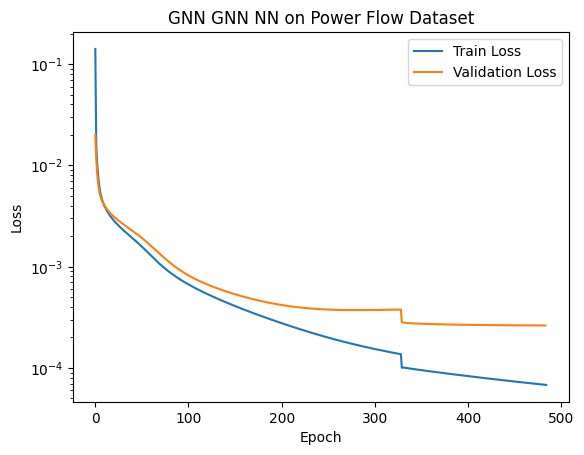

Last epoch: 484, Train loss: 0.0000680, Val loss: 0.4678678
Best epoch: 483, Train loss: 0.0000682, Val loss: 0.0002628


In [17]:
import matplotlib.pyplot as plt

plt.title('GNN GNN NN on Power Flow Dataset')
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

print(f"Last epoch: {epoch}, Train loss: {train_loss:.7f}, Val loss: {val_loss:.7f}")
print(f"Best epoch: {best_epoch}, Train loss: {best_train_loss:.7f}, Val loss: {best_val_loss:.7f}")


# **Model Evaluation**

In [19]:
model.eval()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Function to calculate regression metrics
def evaluate_regression_metrics(y_true, y_pred):
    # Denormalize the outputs
    y_true = denormalize_output(y_true, y_val_mean, y_val_std)
    y_pred = denormalize_output(y_pred, y_val_mean, y_val_std)

    # Convert to numpy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    nrmse = rmse / np.std(y_true)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Print metrics
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Normalized RMSE (NRMSE): {nrmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R^2 Score: {r2:.6f}")

    return mse, rmse, nrmse, mae, r2

# Evaluation after training
model.eval()
y_val_predictions = []

# Collect all predictions and ground truth for the validation set
with torch.no_grad():
    for batch in val_loader:
        y_val_pred = model(batch)
        y_val_predictions.append(y_val_pred)

# Stack predictions and targets
y_val_predictions = torch.cat(y_val_predictions, dim=0)
y_val_targets = torch.cat([batch.y for batch in val_loader], dim=0)

# Reshape predictions and targets
y_val_predictions = y_val_predictions.view(-1, n_bus * 2)
y_val_targets = y_val_targets.view(-1, n_bus * 2)

# Calculate and print regression metrics
mse, rmse, nrmse, mae, r2 = evaluate_regression_metrics(y_val_targets, y_val_predictions)

# Save the metrics to a dictionary for later comparison
metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'NRMSE': nrmse,
    'MAE': mae,
    'R2': r2
}

# Optionally save the metrics to file
import pandas as pd
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("14_bus_validation_metrics.csv", index=False)
print("\nMetrics saved to '14_bus_validation_metrics.csv'.")

#metrics_df.to_csv("30_bus_validation_metrics.csv", index=False)
#print("\nMetrics saved to '30_bus_validation_metrics.csv'.")

#metrics_df.to_csv("57_bus_validation_metrics.csv", index=False)
#print("\nMetrics saved to '57_bus_validation_metrics.csv'.")


Mean Squared Error (MSE): 0.000263
Root Mean Squared Error (RMSE): 0.016212
Normalized RMSE (NRMSE): 0.000194
Mean Absolute Error (MAE): 0.009671
R^2 Score: 0.999006

Metrics saved to 'validation_metrics.csv'.


In [20]:
model.eval()

# Evaluation on a single training datapoint
y_train_pred = model(train_loader.dataset[0])
train_loss_1 = MSE(denormalize_output(y_train_pred, y_val_mean, y_val_std), denormalize_output(y_norm_train[0], y_val_mean, y_val_std))
print("[1 datapoint] Train ground-truth:", y_raw_train[0].detach().numpy())
print("[1 datapoint] Train prediction:", denormalize_output(y_train_pred, y_val_mean, y_val_std).detach().numpy())
print(f"[1 datapoint] Train loss (MSE): {train_loss_1:.7f}")

# Evaluation on a single validation datapoint
y_val_pred = model(val_loader.dataset[0])
val_loss_1 = MSE(denormalize_output(y_val_pred, y_val_mean, y_val_std), denormalize_output(y_norm_val[0], y_val_mean, y_val_std))
print("[1 datapoint] Val ground-truth:", y_raw_val[0].detach().numpy())
print("[1 datapoint] Val prediction:", denormalize_output(y_val_pred, y_val_mean, y_val_std).detach().numpy())
print(f"[1 datapoint] Val loss (MSE): {val_loss_1:.7f}")


[1 datapoint] Train ground-truth: [  10.324 -154.216    9.882 -156.117    9.753 -156.712    9.724 -156.839
    9.659 -157.161    9.607 -157.399    9.617 -157.37     9.627 -157.311
    9.581 -157.512    9.56  -157.633    9.773 -156.613    9.682 -157.039
    9.658 -157.152    9.664 -157.123]
[1 datapoint] Train prediction: [  10.32436 -154.20943    9.88266 -156.10844    9.75356 -156.70706
    9.72556 -156.83072    9.66007 -157.1534     9.60873 -157.38504
    9.61776 -157.36098    9.62839 -157.3038     9.58461 -157.49806
    9.56193 -157.61293    9.77318 -156.61003    9.68424 -157.03433
    9.66011 -157.14351    9.66575 -157.11386]
[1 datapoint] Train loss (MSE): 0.0000388
[1 datapoint] Val ground-truth: [  10.302 -154.788    9.844 -156.745    9.686 -157.465    9.685 -157.484
    9.574 -157.989    9.568 -158.053    9.543 -158.141    9.532 -158.187
    9.518 -158.294    9.535 -158.209    9.727 -157.275    9.629 -157.731
    9.599 -157.869    9.594 -157.896]
[1 datapoint] Val prediction: [ 

# **Testing on Multiple Datasets**

In [24]:
best_model = My_GNN_GNN_NN(n_bus, feat_in, feat_size1, feat_size2, hidden_size1, output_size)

# Load the saved state dictionary
state_dict = torch.load("[14 bus] Best_GNN_GNN_NN_model.pt")
#state_dict = torch.load("[30 bus] Best_GNN_GNN_NN_model.pt")
#state_dict = torch.load("[57 bus] Best_GNN_GNN_NN_model.pt")

best_model.load_state_dict(state_dict)

# Set the model to evaluation mode
best_model.eval()

<ipython-input-24-d1e4fc2b466c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("[PyG] [14 bus] Best_GNN_GNN_NN_model.pt")


My_GNN_GNN_NN(
  (conv1): GCNConv(2, 8)
  (conv2): GCNConv(8, 4)
  (lin1): Linear(in_features=56, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=28, bias=True)
)

In [26]:
def NRMSE(yhat, y):
    rmse = torch.sqrt(torch.mean((yhat - y) ** 2))
    nrmse = rmse / torch.std(y)
    return nrmse

In [27]:
test_loss_list = []

for i in range(10):
    dataset = pd.read_excel(f'/content/GNN-OptimalPowerFlow/jupyter notebook/dataset/Grid_14 bus_{i + 1}.xlsx').values
    test_dataset = slice_dataset(dataset, 8)
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, _, _, _, _ = normalize_dataset(x_raw_test, y_raw_test)

    data_test_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_test, y_norm_test)]
    test_loader = DataLoader(data_test_list, batch_size=1)

    test_loss = 0
    yhat = torch.empty(0, n_bus * 2)
    for batch in test_loader:
        y_pred = best_model(batch)
        yhat = torch.cat((yhat, y_pred.view(1, -1)))

    yhat = denormalize_output(yhat, y_val_mean, y_val_std)
    test_loss_NRMSE = NRMSE(yhat, y_raw_test)

    print(f"Dataset {i + 1} | Test loss (NRMSE): {test_loss_NRMSE:.7f}")
    test_loss_list.append(test_loss_NRMSE)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 1 | Test loss (NRMSE): 0.0002095


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 2 | Test loss (NRMSE): 0.0001943


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 3 | Test loss (NRMSE): 0.0001995


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 4 | Test loss (NRMSE): 0.0002290


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 5 | Test loss (NRMSE): 0.0002516


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 6 | Test loss (NRMSE): 0.0001987


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 7 | Test loss (NRMSE): 0.0003747


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 8 | Test loss (NRMSE): 0.0005161


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 9 | Test loss (NRMSE): 0.0002261


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 10 | Test loss (NRMSE): 0.0004208


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 11 | Test loss (NRMSE): 0.0003316


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 12 | Test loss (NRMSE): 0.0002865


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 13 | Test loss (NRMSE): 0.0002028


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 14 | Test loss (NRMSE): 0.0002147


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 15 | Test loss (NRMSE): 0.0002133


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 16 | Test loss (NRMSE): 0.0002421


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 17 | Test loss (NRMSE): 0.0002568


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 18 | Test loss (NRMSE): 0.0002829


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 19 | Test loss (NRMSE): 0.0002054


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 20 | Test loss (NRMSE): 0.0002482


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 21 | Test loss (NRMSE): 0.0003200


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 22 | Test loss (NRMSE): 0.0002926


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 23 | Test loss (NRMSE): 0.0002473


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 24 | Test loss (NRMSE): 0.0004114


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 25 | Test loss (NRMSE): 0.0003111


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 26 | Test loss (NRMSE): 0.0002337


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 27 | Test loss (NRMSE): 0.0003020


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 28 | Test loss (NRMSE): 0.0002455


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 29 | Test loss (NRMSE): 0.0002127


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 30 | Test loss (NRMSE): 0.0004148


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 31 | Test loss (NRMSE): 0.0003674


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 32 | Test loss (NRMSE): 0.0001855


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 33 | Test loss (NRMSE): 0.0002888


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 34 | Test loss (NRMSE): 0.0002272


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 35 | Test loss (NRMSE): 0.0004344


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 36 | Test loss (NRMSE): 0.0002356


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 37 | Test loss (NRMSE): 0.0001974


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 38 | Test loss (NRMSE): 0.0003367


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 39 | Test loss (NRMSE): 0.0002926


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 40 | Test loss (NRMSE): 0.0003836


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 41 | Test loss (NRMSE): 0.0002361


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 42 | Test loss (NRMSE): 0.0002531


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 43 | Test loss (NRMSE): 0.0002360


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 44 | Test loss (NRMSE): 0.0002286


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 45 | Test loss (NRMSE): 0.0002239


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 46 | Test loss (NRMSE): 0.0002371


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 47 | Test loss (NRMSE): 0.0002316


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 48 | Test loss (NRMSE): 0.0002576


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 49 | Test loss (NRMSE): 0.0003063


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 50 | Test loss (NRMSE): 0.0002411


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 51 | Test loss (NRMSE): 0.0002475


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 52 | Test loss (NRMSE): 0.0002501


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 53 | Test loss (NRMSE): 0.0002639


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 54 | Test loss (NRMSE): 0.0002280


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 55 | Test loss (NRMSE): 0.0002472


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 56 | Test loss (NRMSE): 0.0003015


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 57 | Test loss (NRMSE): 0.0002308


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 58 | Test loss (NRMSE): 0.0002724


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 59 | Test loss (NRMSE): 0.0002402


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 60 | Test loss (NRMSE): 0.0002262


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 61 | Test loss (NRMSE): 0.0002497


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 62 | Test loss (NRMSE): 0.0002549


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 63 | Test loss (NRMSE): 0.0002976


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 64 | Test loss (NRMSE): 0.0002231


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 65 | Test loss (NRMSE): 0.0002026


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 66 | Test loss (NRMSE): 0.0002315


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 67 | Test loss (NRMSE): 0.0002260


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 68 | Test loss (NRMSE): 0.0002500


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 69 | Test loss (NRMSE): 0.0002723


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 70 | Test loss (NRMSE): 0.0004067


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 71 | Test loss (NRMSE): 0.0002416


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 72 | Test loss (NRMSE): 0.0002616


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 73 | Test loss (NRMSE): 0.0004603


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 74 | Test loss (NRMSE): 0.0002254


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 75 | Test loss (NRMSE): 0.0003029


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 76 | Test loss (NRMSE): 0.0002025


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 77 | Test loss (NRMSE): 0.0002342


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 78 | Test loss (NRMSE): 0.0002847


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 79 | Test loss (NRMSE): 0.0002023


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 80 | Test loss (NRMSE): 0.0003112


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 81 | Test loss (NRMSE): 0.0002211


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 82 | Test loss (NRMSE): 0.0003614


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 83 | Test loss (NRMSE): 0.0002367


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 84 | Test loss (NRMSE): 0.0003276


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 85 | Test loss (NRMSE): 0.0002196


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 86 | Test loss (NRMSE): 0.0004222


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 87 | Test loss (NRMSE): 0.0002839


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 88 | Test loss (NRMSE): 0.0002288


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 89 | Test loss (NRMSE): 0.0002221


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 90 | Test loss (NRMSE): 0.0002877


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 91 | Test loss (NRMSE): 0.0002259


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 92 | Test loss (NRMSE): 0.0003299


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 93 | Test loss (NRMSE): 0.0005751


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 94 | Test loss (NRMSE): 0.0002721


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 95 | Test loss (NRMSE): 0.0002123


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 96 | Test loss (NRMSE): 0.0003042


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 97 | Test loss (NRMSE): 0.0001777


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 98 | Test loss (NRMSE): 0.0003940


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 99 | Test loss (NRMSE): 0.0002464


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 100 | Test loss (NRMSE): 0.0002115


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 101 | Test loss (NRMSE): 0.0001971


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset 102 | Test loss (NRMSE): 0.0003324


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [31]:
# Save test losses to Excel
new_list = []
for x in test_loss_list:
    new_list.append(x.detach().numpy())

test_loss_df = pd.DataFrame(new_list, columns=["Test Loss"])
test_loss_df.to_excel("[14 bus] Test Losses.xlsx", index=False)
print("\nTest loss file saved!")


Test loss file saved!


# **IEEE 30 Bus DataSet Generation**

It Contains 30 buses, 6 generators, 21 loads, and 41 branches.

A classic test case for load flow and optimal power flow (OPF) studies.


In [1]:
pip install pandapower

In [10]:
import pandapower as pp
import pandapower.networks as nw
import pandas as pd
import random
import os

# Create the output folder
output_folder = "datasets_30Bus"
os.makedirs(output_folder, exist_ok=True)

# Create the 30-bus test system using pandapower
net = nw.case30()

# Number of datasets and samples per dataset
num_datasets = 10
samples_per_dataset = 2000
variation_range = 0.4  # ±40% random load variation

# columns for the output Excel file
bus_ids = net.bus.index
columns = []

# column names based on dataset format
for bus in bus_ids:
    columns.extend([f"P_{bus + 1} (PQ)", f"Q_{bus + 1} (PQ)", f"V_{bus + 1}", f"d_{bus + 1}"])

# Store original load values for resetting
original_p_values = net.load['p_mw'].copy()
original_q_values = net.load['q_mvar'].copy()

# Generate the datasets
for dataset_n in range(1, num_datasets + 1):
    print(f"Generating dataset {dataset_n}...")

    data = []

    # initial power flow to stabilize the network
    #try:
    #    pp.runpp(net, algorithm='nr', max_iteration=20)
    #except pp.LoadflowNotConverged:
    #    print(f"Initial load flow did not converge for dataset {dataset_n}, skipping this dataset.")
    #    continue

    for sample in range(1, samples_per_dataset + 1):
        # Reset the load values to the original values
        net.load['p_mw'] = original_p_values
        net.load['q_mvar'] = original_q_values

        # Apply random variation based on the original values
        for load in net.load.index:
            net.load.at[load, 'p_mw'] = original_p_values[load] * (1 + random.uniform(-variation_range, variation_range))
            net.load.at[load, 'q_mvar'] = original_q_values[load] * (1 + random.uniform(-variation_range, variation_range))

        # Run AC power flow with Newton-Raphson algorithm
        try:
            pp.runpp(net, algorithm='nr', max_iteration=20)
        except pp.LoadflowNotConverged:
            print(f"Load flow did not converge for sample {sample} in dataset {dataset_n}, skipping this sample.")
            continue

        # Collect data for the current sample
        row = []

        for bus in bus_ids:
            # Extract P and Q values for the bus (PQ buses only)
            if bus in net.load['bus'].values:
                p_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'p_mw'].sum()
                q_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'q_mvar'].sum()
            else:
                p_load, q_load = 0, 0

            # Extract V (voltage magnitude) and d (voltage angle)
            v_mag = net.res_bus.at[bus, 'vm_pu']
            v_ang = net.res_bus.at[bus, 'va_degree']

            # Append data to the row in the specified format
            row.extend([p_load, q_load, v_mag, v_ang])

        # Add the row to the dataset
        data.append(row)

    # Create a DataFrame and add headers in the requested format
    df = pd.DataFrame(data, columns=columns)

    df.insert(0, "Data", [f"Data {i + 1}" for i in range(len(df))])
    df.insert(0, "Dataset", [f"PF Dataset_{dataset_n}"] + [""] * (len(df) - 1))

    # Save the DataFrame to Excel
    output_filename = os.path.join(output_folder, f"PF_Dataset_{dataset_n}.xlsx")
    df.to_excel(output_filename, index=False)
    print(f"Dataset {dataset_n} saved to {output_filename}")

print("All datasets generated successfully.")


Generating dataset 1...
Dataset 1 saved to datasets/PF_Dataset_1.xlsx
Generating dataset 2...
Dataset 2 saved to datasets/PF_Dataset_2.xlsx
Generating dataset 3...
Dataset 3 saved to datasets/PF_Dataset_3.xlsx
Generating dataset 4...
Dataset 4 saved to datasets/PF_Dataset_4.xlsx
Generating dataset 5...
Dataset 5 saved to datasets/PF_Dataset_5.xlsx
Generating dataset 6...
Dataset 6 saved to datasets/PF_Dataset_6.xlsx
Generating dataset 7...
Dataset 7 saved to datasets/PF_Dataset_7.xlsx
Generating dataset 8...
Dataset 8 saved to datasets/PF_Dataset_8.xlsx
Generating dataset 9...
Dataset 9 saved to datasets/PF_Dataset_9.xlsx
Generating dataset 10...
Dataset 10 saved to datasets/PF_Dataset_10.xlsx
All datasets generated successfully.


 **30 Bus Generator Limits**

 Generated Active and Reactive Power (P and Q) should be bounded by their maximum and minimum capability for each bus.

 Otherwise the OPF will not converge for the network.

In [6]:
# Import pandas for cleaner output (optional)
import pandas as pd

# generator bus information
gen_buses = net.gen['bus'].values  # The bus indices with generators
p_gen = net.res_gen['p_mw'].values
q_gen = net.res_gen['q_mvar'].values

# detailed information for each generator
print("Generator Information:")
for i, bus in enumerate(gen_buses):
    p_max = net.gen.at[i, 'max_p_mw'] if 'max_p_mw' in net.gen.columns else "N/A"
    q_max = net.gen.at[i, 'max_q_mvar'] if 'max_q_mvar' in net.gen.columns else "N/A"
    print(f"Bus {bus} | Active Power (P_gen): {p_gen[i]:.2f} MW | Reactive Power (Q_gen): {q_gen[i]:.2f} MVar | P_max: {p_max} MW | Q_max: {q_max} MVar")

print("\nFull Generator DataFrame:")
print(net.gen)


Generator Information:
Bus 1 | Active Power (P_gen): 60.97 MW | Reactive Power (Q_gen): 37.38 MVar | P_max: 80.0 MW | Q_max: 60.0 MVar
Bus 21 | Active Power (P_gen): 21.59 MW | Reactive Power (Q_gen): 40.45 MVar | P_max: 50.0 MW | Q_max: 62.5 MVar
Bus 26 | Active Power (P_gen): 26.91 MW | Reactive Power (Q_gen): 11.79 MVar | P_max: 55.0 MW | Q_max: 48.7 MVar
Bus 22 | Active Power (P_gen): 19.20 MW | Reactive Power (Q_gen): 7.34 MVar | P_max: 30.0 MW | Q_max: 40.0 MVar
Bus 12 | Active Power (P_gen): 37.00 MW | Reactive Power (Q_gen): 10.96 MVar | P_max: 40.0 MW | Q_max: 44.7 MVar

Full Generator DataFrame:
   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  60.97    1.0     NaN       -20.0        60.0      1.0  False   
1  None   21  21.59    1.0     NaN       -15.0        62.5      1.0  False   
2  None   26  26.91    1.0     NaN       -15.0        48.7      1.0  False   
3  None   22  19.20    1.0     NaN       -10.0        40.0      1.0  False 

In [4]:
import pandas as pd

# Initialize lists to track generator outputs
p_gen_list = []
q_gen_list = []

# Run power flow and log generator outputs for multiple test cases
for i in range(10):  # 10 datasets
    try:
        pp.runpp(net, algorithm='nr', max_iteration=20)

        # Get generator active and reactive power outputs
        p_gen = net.res_gen['p_mw'].values
        q_gen = net.res_gen['q_mvar'].values

        # Log the generator outputs
        p_gen_list.append(p_gen)
        q_gen_list.append(q_gen)

        print(f"Test Case {i + 1}:")
        print("Active Power (P_gen):", p_gen)
        print("Reactive Power (Q_gen):", q_gen)
        print("=" * 40)

    except pp.LoadflowNotConverged:
        print(f"Load flow did not converge for Test Case {i + 1}, skipping...")
        continue

# Convert to DataFrame for easier comparison
p_gen_df = pd.DataFrame(p_gen_list, columns=[f"P_gen_{i}" for i in range(len(p_gen))])
q_gen_df = pd.DataFrame(q_gen_list, columns=[f"Q_gen_{i}" for i in range(len(q_gen))])

# Save the results to Excel for further analysis
p_gen_df.to_excel("P_gen_changes.xlsx", index=False)
q_gen_df.to_excel("Q_gen_changes.xlsx", index=False)

print("Generator outputs logged and saved to 'P_gen_changes.xlsx' and 'Q_gen_changes.xlsx'.")


Test Case 1:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 2:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 3:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 4:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 5:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 6:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power (Q_gen): [37.38115789 40.44738087 11.79165197  7.33633467 10.95915525]
Test Case 7:
Active Power (P_gen): [60.97 21.59 26.91 19.2  37.  ]
Reactive Power 

# **IEEE 57 Bus DataSet Generation**

Contains 57 buses, 7 generators, 42 loads, and 80 branches.

Commonly used for testing load flow and contingency analysis.

In [12]:
pip install pandapower

In [13]:
import pandapower as pp
import pandapower.networks as nw
import pandas as pd
import random
import os

# Create the output folder
output_folder = "datasets_57Bus"
os.makedirs(output_folder, exist_ok=True)

# Load the 57-bus test system using pandapower
net = nw.case57()

# Number of datasets and samples per dataset
num_datasets = 10
samples_per_dataset = 2000
variation_range = 0.4  # ±40% random load variation

# Define the columns for the output Excel file
bus_ids = net.bus.index
columns = []

# Create column names based on your dataset format
for bus in bus_ids:
    columns.extend([f"P_{bus + 1} (PQ)", f"Q_{bus + 1} (PQ)", f"V_{bus + 1}", f"d_{bus + 1}"])

# Store original load values for resetting
original_p_values = net.load['p_mw'].copy()
original_q_values = net.load['q_mvar'].copy()

# Generate the datasets
for dataset_n in range(1, num_datasets + 1):
    print(f"Generating dataset {dataset_n}...")

    data = []

    for sample in range(1, samples_per_dataset + 1):
        # Reset the load values to the original values
        net.load['p_mw'] = original_p_values
        net.load['q_mvar'] = original_q_values

        # Apply random variation based on the original values
        for load in net.load.index:
            net.load.at[load, 'p_mw'] = original_p_values[load] * (1 + random.uniform(-variation_range, variation_range))
            net.load.at[load, 'q_mvar'] = original_q_values[load] * (1 + random.uniform(-variation_range, variation_range))

        # Run AC power flow with Newton-Raphson algorithm
        try:
            pp.runpp(net, algorithm='nr', max_iteration=30)
        except pp.LoadflowNotConverged:
            print(f"Load flow did not converge for sample {sample} in dataset {dataset_n}, skipping this sample.")
            continue

        # Collect data for the current sample
        row = []

        for bus in bus_ids:
            # Extract P and Q values for the bus (PQ buses only)
            if bus in net.load['bus'].values:
                p_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'p_mw'].sum()
                q_load = net.res_load.loc[net.load[net.load['bus'] == bus].index, 'q_mvar'].sum()
            else:
                p_load, q_load = 0, 0

            # Extract V (voltage magnitude) and d (voltage angle)
            v_mag = net.res_bus.at[bus, 'vm_pu']
            v_ang = net.res_bus.at[bus, 'va_degree']

            # Append data to the row in the specified format
            row.extend([p_load, q_load, v_mag, v_ang])

        # Add the row to the dataset
        data.append(row)

    # Create a DataFrame and add headers in the requested format
    df = pd.DataFrame(data, columns=columns)
    df.insert(0, "Data", [f"Data {i + 1}" for i in range(len(df))])
    df.insert(0, "Dataset", [f"PF Dataset_{dataset_n}"] + [""] * (len(df) - 1))

    # Save the DataFrame to Excel
    output_filename = os.path.join(output_folder, f"PF_Dataset_{dataset_n}.xlsx")
    df.to_excel(output_filename, index=False)
    print(f"Dataset {dataset_n} saved to {output_filename}")

print("All datasets generated successfully.")


Generating dataset 1...
Dataset 1 saved to datasets_57Bus/PF_Dataset_1.xlsx
Generating dataset 2...
Dataset 2 saved to datasets_57Bus/PF_Dataset_2.xlsx
Generating dataset 3...
Dataset 3 saved to datasets_57Bus/PF_Dataset_3.xlsx
Generating dataset 4...
Dataset 4 saved to datasets_57Bus/PF_Dataset_4.xlsx
Generating dataset 5...
Dataset 5 saved to datasets_57Bus/PF_Dataset_5.xlsx
Generating dataset 6...
Dataset 6 saved to datasets_57Bus/PF_Dataset_6.xlsx
Generating dataset 7...
Dataset 7 saved to datasets_57Bus/PF_Dataset_7.xlsx
Generating dataset 8...
Dataset 8 saved to datasets_57Bus/PF_Dataset_8.xlsx
Generating dataset 9...
Dataset 9 saved to datasets_57Bus/PF_Dataset_9.xlsx
Generating dataset 10...
Dataset 10 saved to datasets_57Bus/PF_Dataset_10.xlsx
All datasets generated successfully.


**57 Bus Generator Limits**

 Generated Active and Reactive Power (P and Q) should be bounded by their maximum and minimum capability for each bus.

 Otherwise the OPF will not converge for the network.

In [15]:
# Import pandas for cleaner output
import pandas as pd

# generator bus information
gen_buses = net.gen['bus'].values  # The bus indices with generators
p_gen = net.res_gen['p_mw'].values
q_gen = net.res_gen['q_mvar'].values

# detailed information for each generator
print("Generator Information:")
for i, bus in enumerate(gen_buses):
    p_max = net.gen.at[i, 'max_p_mw'] if 'max_p_mw' in net.gen.columns else "N/A"
    q_max = net.gen.at[i, 'max_q_mvar'] if 'max_q_mvar' in net.gen.columns else "N/A"
    print(f"Bus {bus} | Active Power (P_gen): {p_gen[i]:.2f} MW | Reactive Power (Q_gen): {q_gen[i]:.2f} MVar | P_max: {p_max} MW | Q_max: {q_max} MVar")

print("\nFull Generator DataFrame:")
print(net.gen)


Generator Information:
Bus 1 | Active Power (P_gen): 0.00 MW | Reactive Power (Q_gen): 29.40 MVar | P_max: 100.0 MW | Q_max: 50.0 MVar
Bus 2 | Active Power (P_gen): 40.00 MW | Reactive Power (Q_gen): -9.46 MVar | P_max: 140.0 MW | Q_max: 60.0 MVar
Bus 5 | Active Power (P_gen): 0.00 MW | Reactive Power (Q_gen): 12.11 MVar | P_max: 100.0 MW | Q_max: 25.0 MVar
Bus 7 | Active Power (P_gen): 450.00 MW | Reactive Power (Q_gen): 74.54 MVar | P_max: 550.0 MW | Q_max: 200.0 MVar
Bus 8 | Active Power (P_gen): 0.00 MW | Reactive Power (Q_gen): -21.24 MVar | P_max: 100.0 MW | Q_max: 9.0 MVar
Bus 11 | Active Power (P_gen): 310.00 MW | Reactive Power (Q_gen): 109.47 MVar | P_max: 410.0 MW | Q_max: 155.0 MVar

Full Generator DataFrame:
   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1    0.0  1.010     NaN       -17.0        50.0      1.0  False   
1  None    2   40.0  0.985     NaN       -10.0        60.0      1.0  False   
2  None    5    0.0  0.980     NaN 

# **Histogram**

Histograms is used to see which architecture has a better and more consistent performance (narrower, left-skewed distribution)

Histograms is used to compare:

1.   Different bus systems (e.g., 14-bus vs. 30-bus vs. 57-bus) using the same GNN architecture.

2.   It can also be used to compare different GNN architectures for a same network to see the effect


**Histogram Goal:**



*   Mean and Median Values: Lower mean and median values indicate better performance.

*   Spread of Distribution: A narrower histogram indicates more consistent performance (less variance).

*   Left-Skewed Distribution: A left-skewed histogram (with most losses near zero) indicates good generalization.



In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the test loss data from each Excel file
bus_14_loss_data = pd.read_excel('[14 bus] Test Losses.xlsx').values.flatten()
bus_30_loss_data = pd.read_excel('[30 bus] Test Losses.xlsx').values.flatten()

# mean and median for each bus system
mean_14 = np.mean(bus_14_loss_data)
median_14 = np.median(bus_14_loss_data)

mean_30 = np.mean(bus_30_loss_data)
median_30 = np.median(bus_30_loss_data)


# Print the statistics
print(f"14-bus system - Mean: {mean_14:.5f}, Median: {median_14:.5f}")
print(f"30-bus system - Mean: {mean_30:.5f}, Median: {median_30:.5f}")

# histogram plotting parameters
kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins=20)

# labels for the histograms
label_14 = f"14-bus, Mean: {mean_14:.5f}, Median: {median_14:.5f}"
label_30 = f"30-bus, Mean: {mean_30:.5f}, Median: {median_30:.5f}"

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(bus_14_loss_data, label=label_14, **kwargs)
plt.hist(bus_30_loss_data, label=label_30, **kwargs)

# plot details
plt.title('Comparison of Test Loss Distributions Across Different Test Case Networks')
plt.xlabel('Test Loss (MSE or NRMSE)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '[14 bus] Test Losses.xlsx'